<a href="https://colab.research.google.com/github/tomonari-masada/course2024-stats2/blob/main/02_introduction_to_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX+Flax入門

* このnotebookは、以下のthe University of Amsterdamの講義資料を元に作成した。
 * Phillip Lippe, [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html)

* JAXのPros
 * コードの見た目がNumPyとそっくり。
 * just-in-time (JIT) コンパイラでGPUやTPUのハードウェアとしての能力を最大限に利用できる。
 * コンパイル時にコードの最適化も行われる。
 * 一定の制約を満たせば、いったんコンパイルした効率の良いコードを、何度でも使いまわせる。

* JAXのCons
 * JITコンパイラを使えるようなコードを書かなければならない。例えば・・・
 * **side-effectのある関数（namespaceの外側に影響を与える関数）は扱えない。**
   * cf. https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
 * このため、疑似乱数の扱いもやや煩雑となる。
 * **条件によって演算の対象となる配列やテンソルの形が変わる処理は扱えない。**（例：`y = x[x>3]`)

* とはいえ、深層学習で使われる多くの計算は、JAXのJIT compilingの制約を満たす。



* JAX+Flaxの入門として参考になるサイト
 * [JAX 101](https://jax.readthedocs.io/en/latest/jax-101/index.html)
 * [JAX - The Sharp Bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html)
 * [Jax for the Impatient](https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html)


* [Flax](https://flax.readthedocs.io/en/latest/) はJAXの深層学習ライブラリ。
 * 参考： [Flax Basics](https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html)

* [Optax](https://optax.readthedocs.io/en/latest/index.html) は深層学習でよく使われるoptimizerをJAXで実装したもの。

* JAXはPyTorchのDataLoaderやTensorFlowのTensorBoardと組み合わせて使える。
 * 深層学習モデルの定義や学習の部分だけ、JAXに置き換えればよい。


## 準備
* 最初に、ランタイムのタイプをGPUに設定してください。

In [1]:
import os
import math
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

%config InlineBackend.figure_format = 'retina'

## アクセラレータ上のNumPyとしてのJAX

* JAXの基本的なAPIはNumPyと、そっくり。
* 名前も同じ (`jax.numpy`)。
* というわけで、とりあえずはJAXをアクセラレータ上で走るNumPyとみなしてよい。

In [2]:
import jax
import jax.numpy as jnp

print("Using jax", jax.__version__)

Using jax 0.4.23


### JAXの配列

* 配列の作り方はNumPyとほとんど同じ。

In [3]:
a = jnp.zeros((2, 5), dtype=jnp.float32)
print(a)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [4]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


* だが、classは異なる。

In [5]:
b.__class__

jaxlib.xla_extension.ArrayImpl

* `DeviceArray`型は、NumPyの`ndarray`とは異なり、CPU, GPU, TPUのいずれでも使える。
* PyTorchのように、`.device()`で、どのデバイスにあるかを調べられる。

In [7]:
b.devices()

{cuda(id=0)}

* このようにJAXでは配列がデフォルトでGPU上に作られる。
* 配列のデバイスをCPUへ変えるには、`jax.device_get`を使う。

In [8]:
b_cpu = jax.device_get(b)
print(b_cpu.__class__)

<class 'numpy.ndarray'>


* CPU上に持ってきた配列は、NumPyの`ndarray`になる。
* 逆に、NumPyの配列をアクセラレータに移動させるには、`jax.device_put`を使う。

In [10]:
b_gpu = jax.device_put(b_cpu)
print(f'Device put: {b_gpu.__class__} on {b_gpu.devices()}')

Device put: <class 'jaxlib.xla_extension.ArrayImpl'> on {cuda(id=0)}


* CPUとGPUにある配列を混在させると、デフォルトで計算結果はGPUに置かれる。

In [11]:
(b_cpu + b_gpu).devices()

{cuda(id=0)}

* 利用可能なデバイス一覧を`jax.devices()`で取得できる。

In [12]:
jax.devices()

[cuda(id=0)]

### JAXにおける擬似乱数

* 計算機が生成する乱数は、本物の乱数ではなく、擬似乱数である。
* 擬似乱数は、現在の状態をもとに、deterministicな計算によって生成される。
 * そして、次の乱数発生で使われる状態も、現在の状態からdeterministicに算出される。
* 擬似乱数の生成は、全てdeterministicな計算によって進行するので、初期値であるシードが同じなら、必ず同じ乱数列が生成される。

* JAXでは、擬似乱数を生成するたびに状態が次から次へと遷移するという、この擬似乱数生成の特徴が、関数を書く上で問題となる。
* というのも、NumPyやPyTorchと同じように、関数の中で乱数を発生させると、関数の外側に影響を与えてしまうからである。
* このように、外側に影響を与える関数は、JAXの考え方に馴染まない。
* そこで、JAXでは、その中で乱数を使う関数に対して、明示的に擬似乱数の状態を渡すのが、コードを書く上での流儀となっている。

* まず、シード`42`に対するPRNG stateを、次のように作成する。

In [13]:
key = jax.random.PRNGKey(42)

* そして、このPRNG stateを乱数の生成に使う。
* 以下のセルを実行し、JAXとNumPyの違いを確認しよう。

In [14]:
# JAXで乱数を生成する望ましくない方法
jax_random_number_1 = jax.random.normal(key)
jax_random_number_2 = jax.random.normal(key)
print('JAX - Random number 1:', jax_random_number_1)
print('JAX - Random number 2:', jax_random_number_2)

# NumPyでは典型的には以下のように乱数を生成する
np.random.seed(42)
np_random_number_1 = np.random.normal()
np_random_number_2 = np.random.normal()
print('NumPy - Random number 1:', np_random_number_1)
print('NumPy - Random number 2:', np_random_number_2)

JAX - Random number 1: -0.18471177
JAX - Random number 2: -0.18471177
NumPy - Random number 1: 0.4967141530112327
NumPy - Random number 2: -0.13826430117118466


* NumPyのように乱数を発生させたいとき、JAXでは、PRNG stateを分岐(split)する。
* そして、splitすることで得られたsubkeyを、乱数を発生させる関数に渡す。
 * 乱数のkeyのsplitには`jax.random.split(...)`を使う。

In [15]:
key, key_ = jax.random.split(key)
jax_random_number_1 = jax.random.normal(key_)
key, key_ = jax.random.split(key)
jax_random_number_2 = jax.random.normal(key_)
print('JAX new - Random number 1:', jax_random_number_1)
print('JAX new - Random number 2:', jax_random_number_2)

JAX new - Random number 1: 1.3694694
JAX new - Random number 2: -0.19947024


* 上のセルを繰り返し実行すると、その度に異なる乱数を得る。
* このようにJAXでは、**乱数を生成させる前にPRNG keyをsplitする**。
 * cf. JAX's tutorial on [Pseudo Random Numbers](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html).

### 自動微分
* JAXでは自動微分が使える。
 * 自動微分について、PyTorchやTensorFlowを代替するライブラリとして利用できる。

* 関数の例
$$ y = \frac{1}{N}\sum_{i=1}^N\left[\left(x_i+2\right)^2+3\right]$$

In [16]:
def simple_graph(x):
  x = x + 2
  x = x ** 2
  x = x + 3
  y = x.mean()
  return y

inp = jnp.arange(3, dtype=jnp.float32)
print('Input', inp)
print('Output', simple_graph(inp))

Input [0. 1. 2.]
Output 12.666667


* PyTorchでの計算グラフに相当するものは、JAXでは
Jaxprと呼ばれる。
 * あえて訳すと「JAX表示式」？
 * cf. https://jax.readthedocs.io/en/latest/jaxpr.html
* `jax.make_jaxpr`を使えば、関数のjaxprが得られる。

In [17]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

* 入力として与える配列の形を変えると、得られるjaxprも変わる。

In [18]:
inp2 = jnp.ones((3, 3), dtype=jnp.float32)
jax.make_jaxpr(simple_graph)(inp2)

{ lambda ; a:f32[3,3]. let
    b:f32[3,3] = add a 2.0
    c:f32[3,3] = integer_pow[y=2] b
    d:f32[3,3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0, 1)] d
    f:f32[] = div e 9.0
  in (f,) }

* 自動微分には`jax.grad`を使う。
 * 自動微分は、関数をtransformして別の関数を得ること、とみなせる。

In [19]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print('Gradient', gradients)

Gradient [1.3333334 2.        2.6666667]


* 勾配だけでなく、関数の出力値も得たいときは`jax.value_and_grad`を使う。

In [20]:
val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

### Just-In-Timeコンパイラ

* JAXには、関数をjust-in-timeでコンパイルする機能が備わっている。
 * コンパイルは、与えられた関数をより高速に実行できる関数へとtransformすること、とみなせる。
* JITコンパイルには`jax.jit`を使う。
 * もしくは、関数の直前で`@jax.jit`というデコレータを用いる。
* コンパイルされた関数は、XLAにより高速化される。
 * https://www.tensorflow.org/xla?hl=ja

In [21]:
jitted_function = jax.jit(simple_graph)

* コンパイルするとどのくらい実行が高速化されるのか、調べる。

In [22]:
# Create a new random subkey for generating new random values
key, key_ = jax.random.split(key)
large_input = jax.random.normal(key_, (10000,))
# Run the jitted function once to start compilation
_ = jitted_function(large_input)

* JAXは、デフォルトで非同期に計算を行う。
 * 計算結果を収める場所だけ先に作っておいて、計算され次第、そこに答えを埋めていく、という感じ。
* そのため、計算の実行時間を測るときは`block_until_ready()`が必要。

In [23]:
%%timeit
simple_graph(large_input).block_until_ready()

846 µs ± 189 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
jitted_function(large_input).block_until_ready()

110 µs ± 3.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


* 微分した結果得られた関数も、コンパイルできる。

In [25]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input)  # Apply once to compile

In [26]:
%%timeit
grad_function(large_input).block_until_ready()

7.49 ms ± 500 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
jitted_grad_function(large_input).block_until_ready()

101 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Flax
* JAXだけ使っても、複雑なニューラルネットワークを実装することはできる。
* しかし、非常に煩雑な作業になる。
* そこで、深層学習むけのコードを書くときには、専用のライブラリを使う。

 * [Flax](https://flax.readthedocs.io/en/latest/index.html), started by the Google Brain Team, focuses on flexibility and clarity.
 * [Haiku](https://dm-haiku.readthedocs.io/en/latest/), from DeepMind, focuses on simplicity and compositionality.
 * [Trax](https://github.com/google/trax), maintained by the Google Brain Team, provides solutions for common training tasks
 * [Equinox](https://github.com/patrick-kidger/equinox), created by Patrick Kidger and Cristian Garcia, implements neural networks as callable PyTrees

* ここではFlaxを使う。



* 以下のようなデータセット(XOR)を二値分類するMLPのtrainingを、Flaxで書いてみる。

<center style="width: 100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/continuous_xor.svg?raw=1" width="350px"></center>

### モデルの定義

* パッケージ`flax.linen`を使うと便利。
 * https://flax.readthedocs.io/en/latest/flax.linen.html

In [28]:
import flax
from flax import linen as nn

#### Flaxの`nn.Module`

* PyTorchの`nn.Module`と似ている。
* 簡単なMLPの実装例を、下に示す。

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/small_neural_network.svg?raw=1" width="300px"></center>

In [29]:
class SimpleClassifier(nn.Module):
  num_hidden : int   # Number of hidden neurons
  num_outputs : int  # Number of output neurons

  def setup(self):
    # Create the modules we need to build the network
    # nn.Dense is a linear layer
    self.linear1 = nn.Dense(features=self.num_hidden)
    self.linear2 = nn.Dense(features=self.num_outputs)

  def __call__(self, x):
    # Perform the calculation of the model to determine the prediction
    x = self.linear1(x)
    x = nn.tanh(x)
    x = self.linear2(x)
    return x

In [30]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
# Printing the model shows its attributes
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


* モデルそのものと、モデル・パラメータの値の特定の設定とは、別々に扱う。

In [31]:
key, key_ = jax.random.split(key)
inp = jax.random.normal(key_, (8, 2))  # Batch size 8, input size 2
# Initialize the model
key, key_ = jax.random.split(key)
params = model.init(key_, inp)
print(params)

{'params': {'linear1': {'kernel': Array([[ 0.2044236 ,  0.81077623,  0.757581  , -0.87514836,  0.07497111,
        -0.32711986,  0.02364202, -0.4966537 ],
       [ 0.04358766, -0.18996277,  1.0238513 ,  0.99894184, -0.43538937,
         0.6912282 ,  1.095237  ,  0.4223418 ]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'linear2': {'kernel': Array([[-0.22855726],
       [-0.12568006],
       [ 0.09575894],
       [-0.24470274],
       [-0.70555496],
       [-0.11271247],
       [-0.06481547],
       [ 0.14784963]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}


* 特定の入力に対する出力を得るときは、モデルパラメータの値の特定の設定も、同時に指定する。

In [32]:
model.apply(params, inp)

Array([[-0.08674173],
       [ 0.07025519],
       [ 0.53430825],
       [ 0.09453899],
       [ 0.07419205],
       [ 0.09579355],
       [-0.11184424],
       [ 0.22507659]], dtype=float32)

### データの準備
* データを扱うためのコードだけ、別途PyTorchで書くことができる。

In [33]:
import torch.utils.data as data

#### データセット

In [34]:
class XORDataset(data.Dataset):

  def __init__(self, size, seed, std=0.1):
    """
    Inputs:
        size - Number of data points we want to generate
        seed - The seed to use to create the PRNG state with which we want to generate the data points
        std - Standard deviation of the noise (see generate_continuous_xor function)
    """
    super().__init__()
    self.size = size
    self.np_rng = np.random.RandomState(seed=seed)
    self.std = std
    self.generate_continuous_xor()

  def generate_continuous_xor(self):
    # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
    # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
    # If x=y, the label is 0.
    data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
    label = (data.sum(axis=1) == 1).astype(np.int32)
    # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
    data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

    self.data = data
    self.label = label

  def __len__(self):
    # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
    return self.size

  def __getitem__(self, idx):
    # Return the idx-th data point of the dataset
    # If we have multiple things to return (data point and label), we can return them as tuple
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

In [35]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), 1)


In [36]:
def visualize_samples(data, label):
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  plt.figure(figsize=(4, 4))
  plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
  plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
  plt.title("Dataset samples")
  plt.ylabel(r"$x_2$")
  plt.xlabel(r"$x_1$")
  plt.legend()

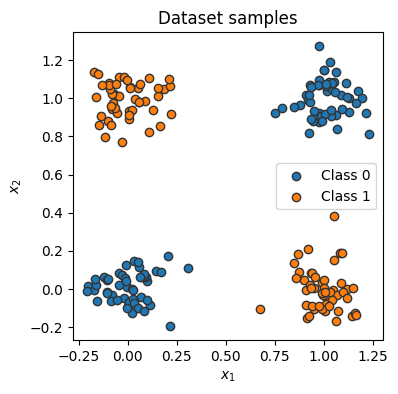

In [38]:
visualize_samples(dataset.data, dataset.label);

#### データローダ

In [39]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [40]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 0.8799704   0.9665499 ]
 [ 1.097512   -0.01470574]
 [ 0.01990597  0.9399783 ]
 [ 1.1628616  -0.13801014]
 [ 0.02140937 -0.12457388]
 [ 1.0638592  -0.166152  ]
 [ 1.0013002   1.1453534 ]
 [-0.07303666  1.0216459 ]]
Data labels (8,) 
 [0 1 1 1 0 1 0 1]


### 最適化アルゴリズム
* `optax`というライブラリを使う。
 * https://optax.readthedocs.io/en/latest/index.html

In [41]:
import optax

In [42]:
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=0.1)

* 訓練の状態を初期化する。

In [43]:
from flax.training import train_state

model_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer,
    )

### 損失関数

* 二値分類なので、クロスエントロピーを損失関数として使う。
  * $y$はラベル。$x$は予測。

$$L_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$
  

In [44]:
def calculate_loss_acc(state, params, batch):
  data_input, labels = batch
  # Obtain the logits and predictions of the model for the input data
  logits = state.apply_fn(params, data_input).squeeze(axis=-1)
  pred_labels = (logits > 0).astype(jnp.float32)
  # Calculate the loss and accuracy
  loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
  acc = (pred_labels == labels).mean()
  return loss, acc

* 試しに損失を計算させてみる。

In [45]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.69340694, dtype=float32), Array(0.625, dtype=float32))

### JITコンパイルによる高速化

In [46]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
  # Gradient function
  grad_fn = jax.value_and_grad(
      calculate_loss_acc, # Function to calculate the loss
      argnums=1, # Parameters are second argument of the function
      has_aux=True, # Function has additional outputs, here accuracy
      )
  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, batch)
  # Perform parameter update with gradients and optimizer
  state = state.apply_gradients(grads=grads)
  # Return state and any other value we might want
  return state, loss, acc

In [47]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
  # Determine the accuracy
  _, acc = calculate_loss_acc(state, state.params, batch)
  return acc

### 訓練

In [48]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [49]:
def train_model(state, data_loader, num_epochs=100):
  # Training loop
  for epoch in tqdm(range(num_epochs)):
    for batch in data_loader:
      state, loss, acc = train_step(state, batch)
      # We could use the loss and accuracy for logging here, e.g. in TensorBoard
      # For simplicity, we skip this part here
  return state

In [50]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

### 評価

In [58]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=numpy_collate,
    )

In [59]:
def eval_model(state, data_loader):
  all_accs, batch_sizes = [], []
  for batch in data_loader:
    batch_acc = eval_step(state, batch)
    all_accs.append(batch_acc)
    batch_sizes.append(batch[0].shape[0])
  # Weighted average since some batches might be smaller
  acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
  print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [60]:
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


#### モデルパラメータのバインディング
* 今まで、モデルそのものと、モデルパラメータの値の特定の設定とを、別々に管理してきた。
* しかし、これでは不便。
* 以下のようにすれば、モデルのインスタンスを、特定のパラメータ値の設定へとbindできる。

In [61]:
trained_model = model.bind(trained_model_state.params)

In [62]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape

(8, 1)

* このほうが、PyTorchっぽい。

#### 分類境界の可視化

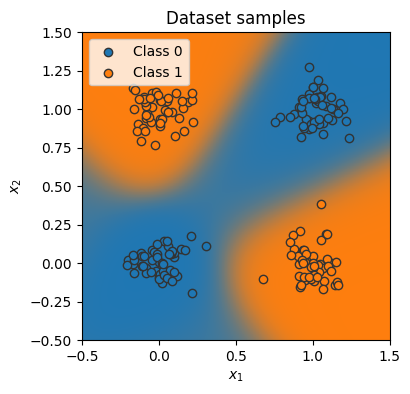

In [64]:
from matplotlib.colors import to_rgba

def visualize_classification(model, data, label):
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  fig = plt.figure(figsize=(4, 4))
  plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
  plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
  plt.title("Dataset samples")
  plt.ylabel(r"$x_2$")
  plt.xlabel(r"$x_1$")
  plt.legend()

  # Let's make use of a lot of operations we have learned above
  c0 = np.array(to_rgba("C0"))
  c1 = np.array(to_rgba("C1"))
  x1 = jnp.arange(-0.5, 1.5, step=0.01)
  x2 = jnp.arange(-0.5, 1.5, step=0.01)
  xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
  model_inputs = np.stack([xx1, xx2], axis=-1)
  logits = model(model_inputs)
  preds = nn.sigmoid(logits)
  output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
  output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
  plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
  plt.grid(False)
  return fig

visualize_classification(trained_model, dataset.data, dataset.label);